In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['Lung_Opacity', 'Normal', 'COVID', 'Viral Pneumonia', 'train', 'test']
⚠ Pas de dossier 'images' trouvé pour train
⚠ Pas de dossier 'images' trouvé pour test


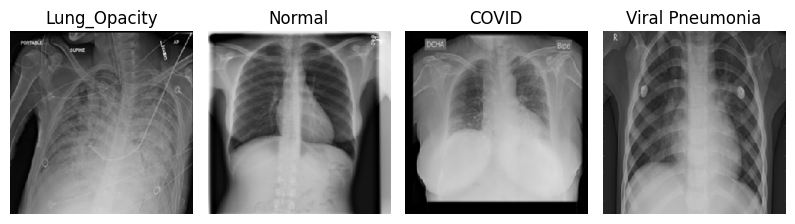

In [ ]:

import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

# Chemin du dataset
base_path = "/content/drive/My Drive/COVID-19_Radiography_Dataset"

# Vérifier les classes (sous-dossiers)
classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Vérifier si on a bien trouvé des classes
if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0

    # Afficher une image par classe
    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name, "images")  # Prendre uniquement les images
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue  # Passer à la classe suivante

        # Lister les fichiers images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(244, 244))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:
# count number of train images for each expression
for expression in os.listdir(base_path + "/train"):  # Iterate through subdirectories of 'train'
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

6014 Lung_Opacity images
9782 Normal images
3480 COVID images
1293 Viral Pneumonia images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Chemin du dossier d'entraînement
train_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 244
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


<ipython-input-4-393eb14497d0>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


Found 5172 validated image filenames belonging to 4 classes.
📊 Nouvelle distribution des classes :
 class
COVID              1293
Lung_Opacity       1293
Normal             1293
Viral Pneumonia    1293
Name: count, dtype: int64


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


local_weights_path = "imagenet"
IMG_SHAPE = (224, 224, 3)


from tensorflow.keras.applications import ResNet50

def create_model():
    baseModel = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=local_weights_path
    )

    print("Number of layers in the base model: ", len(baseModel.layers))

    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,  BatchNormalization
    from tensorflow.keras import models, layers
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.optimizers import Adam
    from keras.models import Sequential

    from tensorflow.keras.regularizers import l2

    for layer in baseModel.layers[:170]:
        layer.trainable = False
    for layer in baseModel.layers[170:]:
        layer.trainable = True

    model = Sequential([
        baseModel,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.7),
        Dense(64, activation='relu',kernel_regularizer=l2(0.001)),
        Dropout(0.6),
        Dense(4, activation='softmax')
    ])


    return model


In [ ]:
model=create_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  175


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,500 (91.01 MB)

 Trainable params: 1,325,508 (5.06 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

Fold 1/5
Found 4137 validated image filenames belonging to 4 classes.
Found 1035 validated image filenames belonging to 4 classes.
Number of layers in the base model:  175


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1669s 13s/step - accuracy: 0.2831 - loss: 1.5968 - val_accuracy: 0.2599 - val_loss: 1.4480
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.3144 - loss: 1.4239 - val_accuracy: 0.3304 - val_loss: 1.4175
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.3347 - loss: 1.3952 - val_accuracy: 0.4483 - val_loss: 1.3561
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.3636 - loss: 1.3535 - val_accuracy: 0.5043 - val_loss: 1.3088
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.3754 - loss: 1.3346 - val_accuracy: 0.5005 - val_loss: 1.2681
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.4048 - loss: 1.2965 - val_accuracy: 0.4705 - val_loss: 1.2804
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.4103 - loss: 1.2809 - val_accuracy: 0.5449 - val_loss: 1.2243
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.4286 -

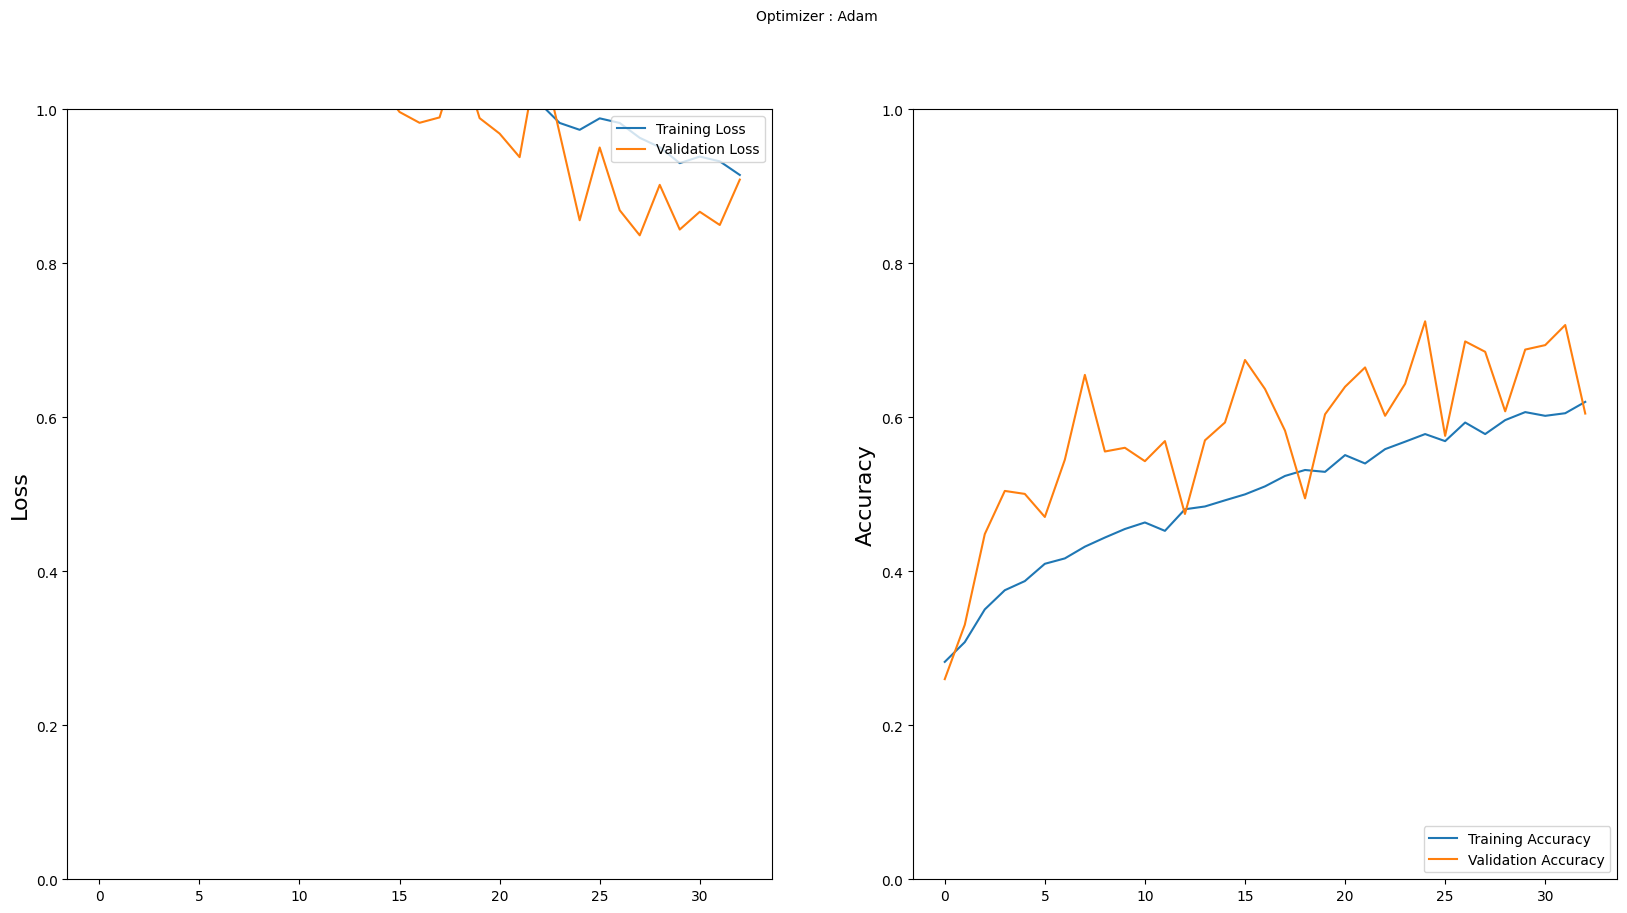

Fold 2/5
Found 4137 validated image filenames belonging to 4 classes.
Found 1035 validated image filenames belonging to 4 classes.
Number of layers in the base model:  175


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 319ms/step - accuracy: 0.2749 - loss: 1.6119 - val_accuracy: 0.2744 - val_loss: 1.4810
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 267ms/step - accuracy: 0.3443 - loss: 1.4116 - val_accuracy: 0.2754 - val_loss: 1.4087
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.3812 - loss: 1.3697 - val_accuracy: 0.4193 - val_loss: 1.3299
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.3870 - loss: 1.3426 - val_accuracy: 0.5362 - val_loss: 1.2810
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.4177 - loss: 1.2949 - val_accuracy: 0.5188 - val_loss: 1.2590
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.4192 - loss: 1.2714 - val_accuracy: 0.5662 - val_loss: 1.1473
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.4483 - loss: 1.2235 - val_accuracy: 0.5874 - val_loss: 1.1403
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.4551 -

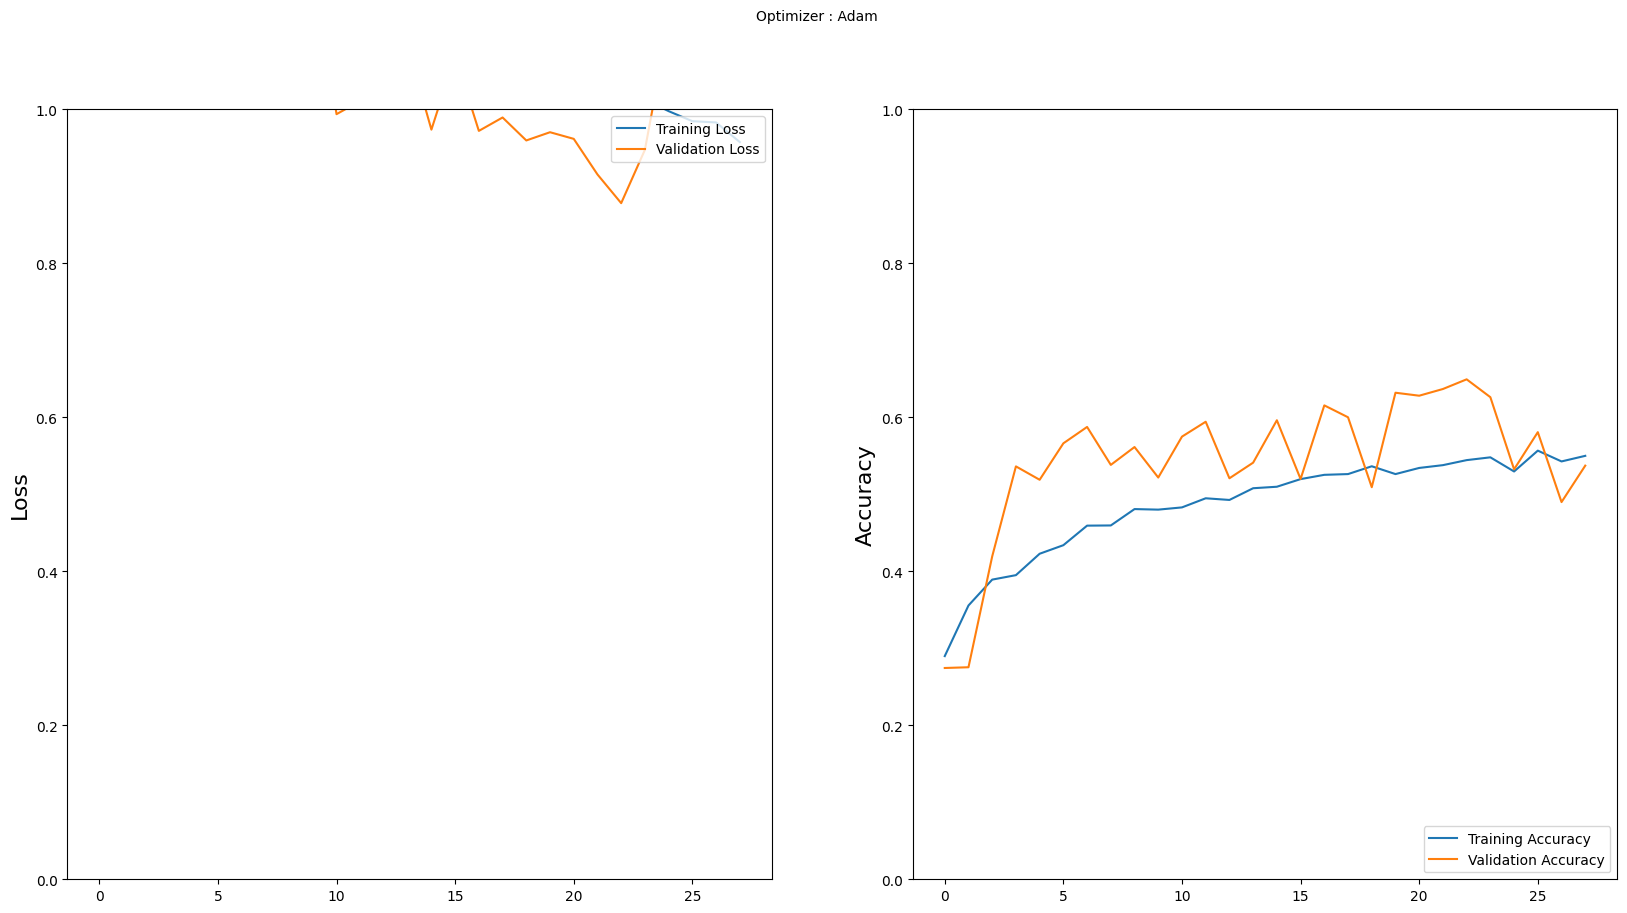

Fold 3/5
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  175


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 322ms/step - accuracy: 0.2593 - loss: 1.6420 - val_accuracy: 0.3201 - val_loss: 1.4557
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.3366 - loss: 1.4137 - val_accuracy: 0.4304 - val_loss: 1.4093
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.3663 - loss: 1.3663 - val_accuracy: 0.4942 - val_loss: 1.3378
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.3803 - loss: 1.3292 - val_accuracy: 0.5048 - val_loss: 1.2729
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.4341 - loss: 1.2776 - val_accuracy: 0.4816 - val_loss: 1.2592
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.4374 - loss: 1.2655 - val_accuracy: 0.5861 - val_loss: 1.1377
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - accuracy: 0.4431 - loss: 1.2312 - val_accuracy: 0.5928 - val_loss: 1.1494
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.4623 -

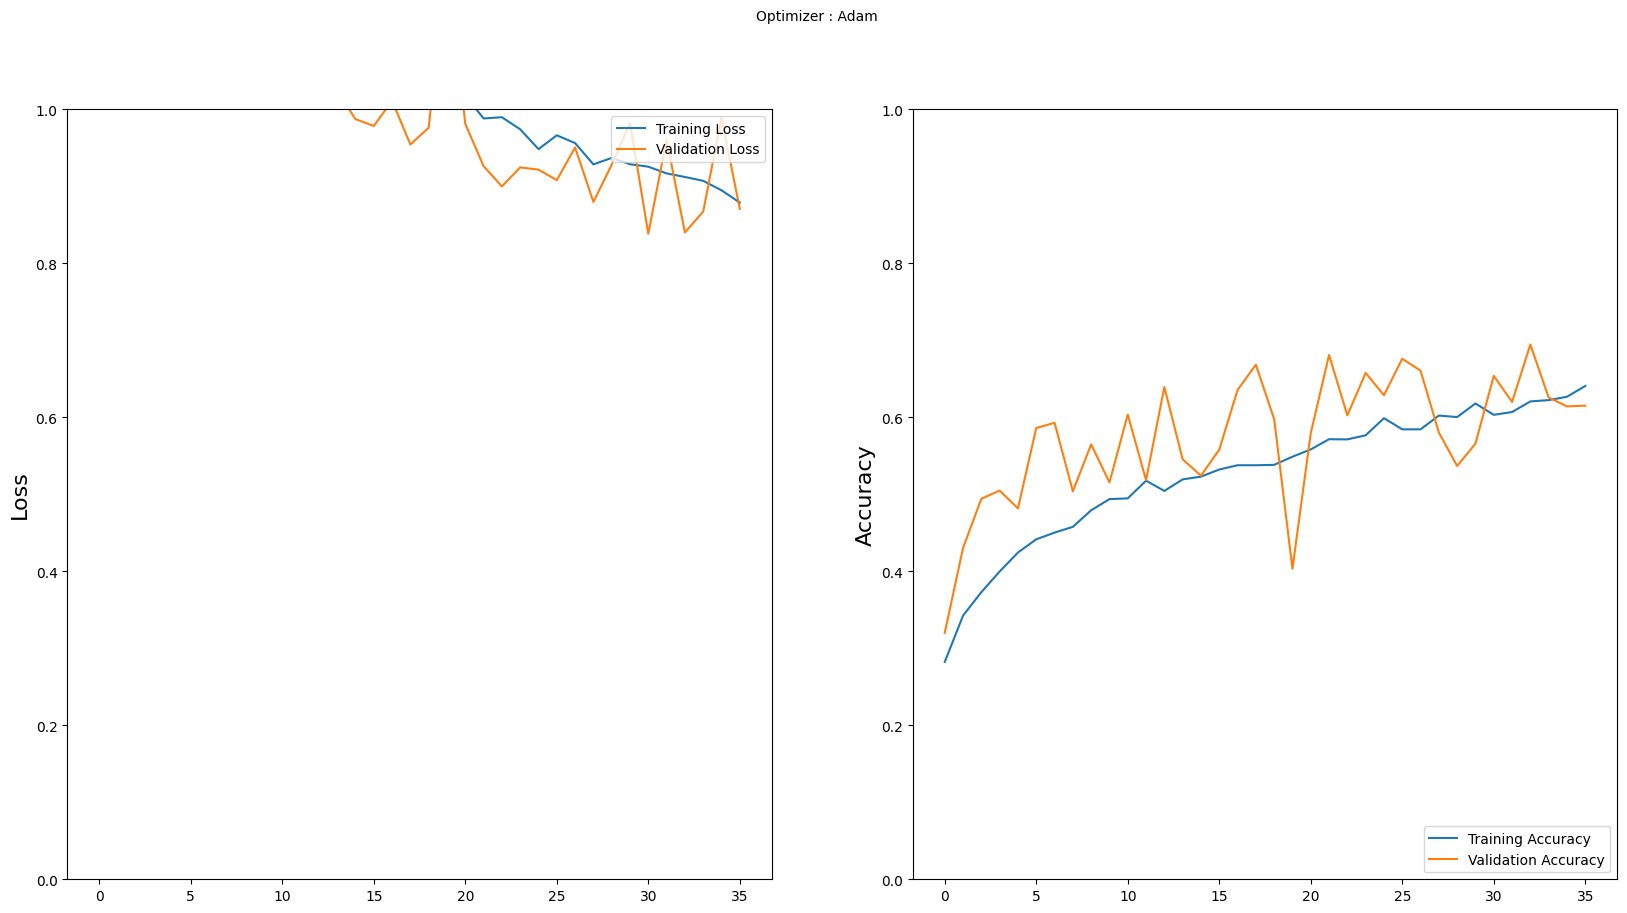

Fold 4/5
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  175


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 302ms/step - accuracy: 0.2490 - loss: 1.6861 - val_accuracy: 0.2582 - val_loss: 1.5019
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.2940 - loss: 1.4448 - val_accuracy: 0.3269 - val_loss: 1.4375
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.3177 - loss: 1.4189 - val_accuracy: 0.4845 - val_loss: 1.3939
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.3405 - loss: 1.3782 - val_accuracy: 0.4362 - val_loss: 1.3517
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.3742 - loss: 1.3499 - val_accuracy: 0.5000 - val_loss: 1.2971
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.3749 - loss: 1.3363 - val_accuracy: 0.5706 - val_loss: 1.2474
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.4045 - loss: 1.3002 - val_accuracy: 0.4845 - val_loss: 1.2551
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.4073 -

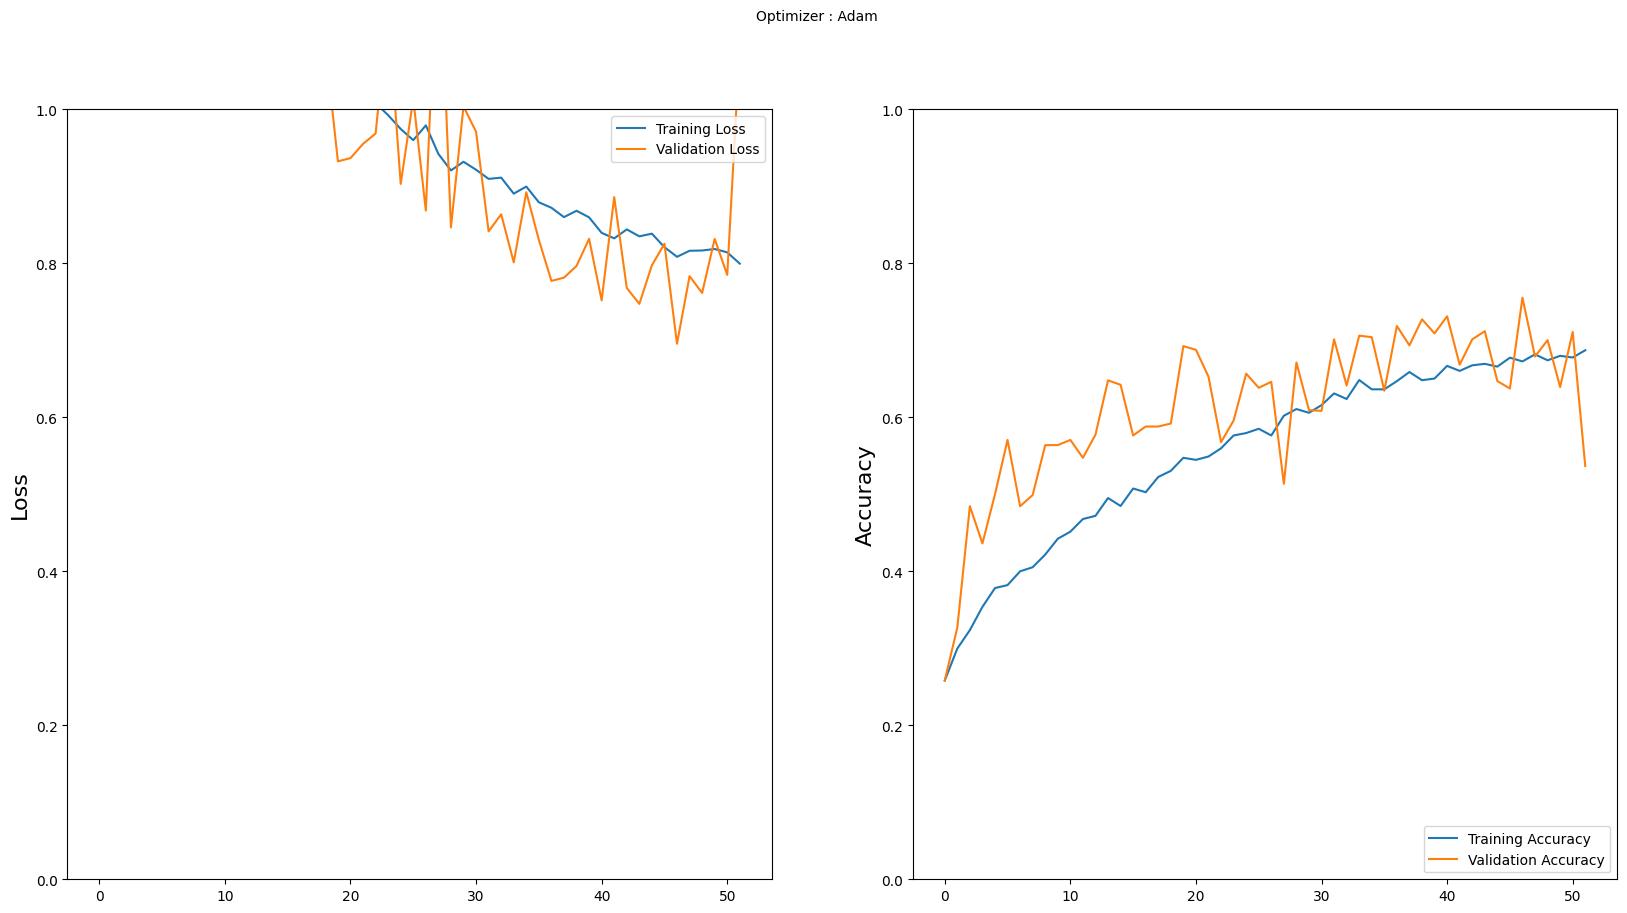

Fold 5/5
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  175


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 300ms/step - accuracy: 0.2666 - loss: 1.6891 - val_accuracy: 0.3414 - val_loss: 1.4744
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - accuracy: 0.3631 - loss: 1.3901 - val_accuracy: 0.2456 - val_loss: 1.4145
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.3820 - loss: 1.3617 - val_accuracy: 0.4197 - val_loss: 1.3191
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.4185 - loss: 1.3015 - val_accuracy: 0.4603 - val_loss: 1.2592
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.4337 - loss: 1.2580 - val_accuracy: 0.4681 - val_loss: 1.2353
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.4475 - loss: 1.2256 - val_accuracy: 0.4468 - val_loss: 1.2246
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.4522 - loss: 1.2202 - val_accuracy: 0.5503 - val_loss: 1.1912
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.4554 -

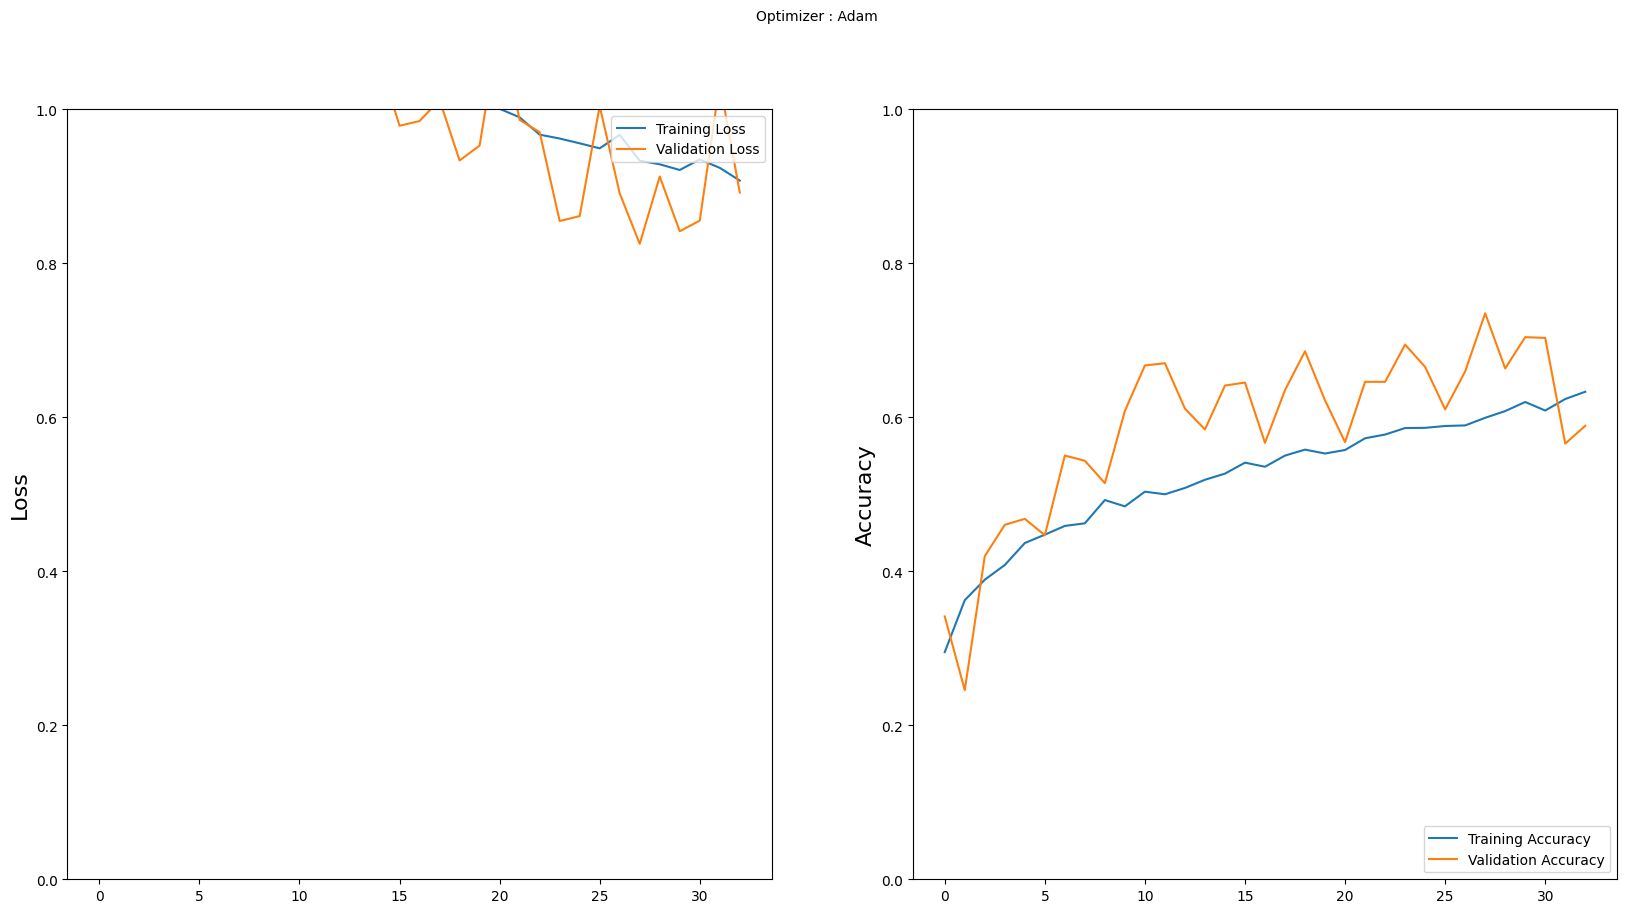

Moyenne des accuracies sur 5 folds: 0.7117


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 4

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]


    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )


    model = create_model()



    model.compile(optimizer = Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")


    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


# Train the model

Everything is set up, let's train our model now!

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [ ]:
model.save('/content/drive/My Drive/covidresnet.hdf5')
print("SAVED")

SAVED


# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/COVID-19_Radiography_Dataset/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='binary',
    shuffle=False
)

Found 8402 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Accuracy: 78.12%


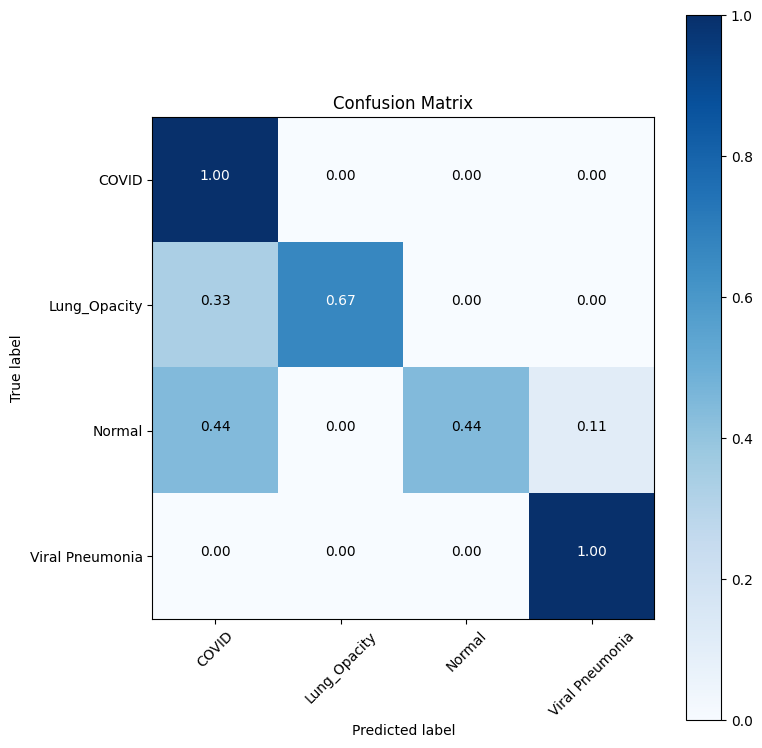

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Affiche la matrice de confusion normalisée"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

X_val_fold, y_val_fold = val_generator[0][0], val_generator[0][1]

# 🔹 Prédictions et calcul de la matrice de confusion
predictions = model.predict(X_val_fold)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val_fold, axis=1)

# 🔹 Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

class_names = list(train_generator.class_indices.keys())

# 🔹 Affichage des résultats
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
